<h1 align="center"> Snowpark Demo: Credit Fraud Detector </h1>



In [146]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import *

In [142]:
import json

with open('creds.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

In [143]:
SF_ACCOUNT = "demo102"
SF_WH = "LOAD_WH"

CONNECTION_PARAMETERS = {
   "account": SF_ACCOUNT,
   "user": username,
   "password": password,
   "database": "AK_TEST",
   "schema": "public",
   "warehouse": SF_WH
}
session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [144]:
print(session.sql("select current_warehouse(), current_database(),current_schema(), current_role()").collect())

[Row(CURRENT_WAREHOUSE()='LOAD_WH', CURRENT_DATABASE()='AK_TEST', CURRENT_SCHEMA()='PUBLIC', CURRENT_ROLE()='DBA_CITIBIKE')]


#### Reset

In [145]:
session.sql("drop function if exists DOUBLE_IT(int)").show()

-----------------------------------
|"status"                         |
-----------------------------------
|DOUBLE_IT successfully dropped.  |
-----------------------------------



#### Use plain SQL

In [134]:
snowdf = session.sql("select AMOUNT, AMOUNT*2 as DBL_AMOUNT from anomaly_base")
snowdf.show()

---------------------------
|"AMOUNT"  |"DBL_AMOUNT"  |
---------------------------
|0         |0             |
|0         |0             |
|0         |0             |
|150       |300           |
|3         |6             |
|379       |758           |
|124       |248           |
|70        |140           |
|4         |8             |
|5         |10            |
---------------------------



#### Convert to Snowpark DF to Pandas DF

In [135]:
pandas_df = snowdf.toPandas()
pandas_df.head()

,AMOUNT,DBL_AMOUNT
0,0,0
1,0,0
2,0,0
3,150,300
4,3,6


<img src="images/pandas_df.png" alt="Pandas Dataframe" width="600"/>

#### With Snowpark, I can now create a Snowflake native dataframe and implement my logic in Python Snowpark Dataframes rather than SQL

In [136]:
snowdf = session.table("anomaly_base")

<img src="images/snowdf.png" alt="Snowpark Dataframe" width="600"/>

#### Perform the same operation using Python dataframe operations that transpile down to SQL

In [137]:
snowdf.select(F.col('AMOUNT'),
              (F.col('AMOUNT')*2).alias('DBL_AMOUNT')).toPandas().head()

,AMOUNT,DBL_AMOUNT
0,0,0
1,0,0
2,0,0
0,150,300
1,3,6


#### I can specify predicates using the filter method or other commonly available dataframe API methods

In [138]:
snowdf.filter(F.col('CLASS')==1).limit(5).toPandas().head()

,TIME,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,AMOUNT,CLASS
0,406,-2,2,-2,4,-1,-1,-3,1,-3,...,1,0,0,0,0,0,0,0,0,1
1,472,-3,-3,1,2,1,-1,0,0,0,...,1,0,1,0,0,0,0,0,529,1
2,4462,-2,2,0,2,-1,0,1,0,0,...,0,-1,0,0,0,-1,0,0,240,1
3,6986,-4,1,-3,3,-1,-2,-3,0,0,...,1,0,0,0,0,-1,-1,1,59,1
4,7519,1,3,-4,5,4,-1,2,0,-1,...,0,-1,-1,-2,1,1,0,0,1,1


#### I can also define my custom logic as a Python UDF that I can push down into Snowflake and then call using SQL or Python

In [139]:
def double_it(x: int) -> int:
    return 2*x

double_udf = udf(double_it, name="double_it")

In [140]:
snowdf.select(F.col('AMOUNT'), double_udf(F.col('AMOUNT'))).toPandas().head()

,AMOUNT,"DOUBLE_IT(""AMOUNT"")"
0,0,0
1,0,0
2,0,0
0,150,300
1,3,6


### Exploratory Data Analysis

#### Pandas provides many methods that help in EDA but is limited in scale because it doesn't scale beyond a single node

In [97]:
pandas_df = snowdf.toPandas()
pandas_df.describe()

,TIME,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,AMOUNT,CLASS
count,284810.000000,284809.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,...,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284810.000000,284809.000000
mean,94812.865163,-0.030919,-0.000583,-0.004312,-0.026221,0.000829,-0.005895,-0.003388,0.020231,0.001194,...,0.019904,-0.014104,0.004838,0.027151,0.002279,0.030799,-0.015695,-0.015951,88.374516,0.001734
std,47488.884280,1.952754,1.671152,1.545462,1.453013,1.409974,1.360235,1.276526,1.208166,1.131759,...,0.726175,0.799909,0.618800,0.669870,0.577135,0.538344,0.402513,0.324652,250.116574,0.041611
min,0.000000,-56.000000,-73.000000,-48.000000,-6.000000,-114.000000,-26.000000,-44.000000,-73.000000,-13.000000,...,-35.000000,-11.000000,-45.000000,-3.000000,-10.000000,-3.000000,-23.000000,-15.000000,0.000000,0.000000
25%,54201.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,...,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,84691.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000
75%,139320.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.000000,0.000000
max,172792.000000,2.000000,22.000000,9.000000,17.000000,35.000000,73.000000,121.000000,20.000000,16.000000,...,27.000000,11.000000,23.000000,5.000000,8.000000,4.000000,32.000000,34.000000,25691.000000,1.000000


#### With the Snowpark DF, you are no longer limited by memory limitations as this `snowdf` exists in Snowflake and not in the memory of this notebook environment

In [98]:
snowdf.select(F.count("V1").alias("count"), 
              F.avg("V1").alias("mean"),
             F.stddev("V1").alias("std"),
             F.min("V1").alias("min"),
             F.max("V1").alias("max"),
             ).show()

------------------------------------------------------------
|"COUNT"  |"MEAN"     |"STD"               |"MIN"  |"MAX"  |
------------------------------------------------------------
|284809   |-0.030919  |1.9527542088035554  |-56    |2      |
------------------------------------------------------------



#### Now lets take a look at our credit transaction data set...

In [99]:
print('No Frauds', (snowdf.filter(F.col('CLASS')==0).count() / snowdf.count() * 100), '% of the dataset')
print('Frauds', (snowdf.filter(F.col('CLASS')==1).count() / snowdf.count() * 100), '% of the dataset')

No Frauds 99.82619992275552 % of the dataset
Frauds 0.1734489659773182 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

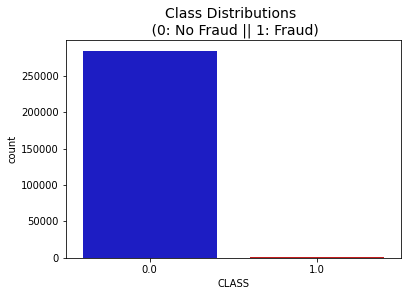

In [100]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('CLASS', data=snowdf.select("CLASS").toPandas(), palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

#### Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

In [101]:
# Lets shuffle the data before creating the subsamples

pandas_df = pandas_df.dropna()
df = pandas_df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['CLASS'] == 1]
non_fraud_df = df.loc[df['CLASS'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.drop(['TIME', 'AMOUNT'], axis=1, inplace=True)
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,CLASS
39772,1.0,0,1,1,-1,0,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
24228,-2.0,2,-6,2,-3,1,0,1,-2,-7,...,0,1,1,1,-1,-2,0,1,0,1.0
57351,-1.0,1,0,-1,0,-1,1,0,-1,-1,...,0,0,1,0,0,0,0,0,0,0.0
47554,-2.0,3,-3,3,0,-1,-2,1,-3,-4,...,0,0,-1,0,-1,0,0,0,0,1.0
18852,-3.0,0,-3,4,-2,-2,-3,1,-2,-5,...,2,1,0,1,0,0,0,1,0,1.0


Distribution of the Classes in the subsample dataset
1.0    0.500508
0.0    0.499492
Name: CLASS, dtype: float64


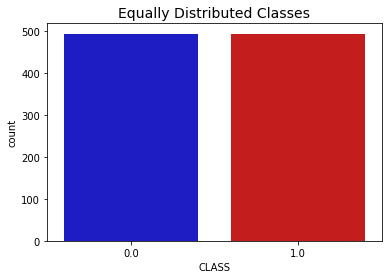

In [102]:

print('Distribution of the Classes in the subsample dataset')
print(new_df['CLASS'].value_counts()/len(new_df))

sns.countplot('CLASS', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

#### Now that we have our dataframe correctly balanced, we can go and train a regression model

## Train a Logistic Regression Model

#### Lets split up the features and the label first

In [103]:
X = new_df.drop('CLASS', axis=1)
y = new_df['CLASS']

#### And split our training and test sets

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Lets create a test dataset along with the CLASS variable that we can use to test our model

In [105]:
combined_df = X_test
combined_df['CLASS'] = y_test.values

#### Save this test data into Snowflake where we want to run inference

In [106]:
%%time
# First create the table
list_val = [i+ " number" for i in combined_df.columns]
query = f""" create or replace table ANOMALY_TEST ({','.join(map(str, list_val))})"""
session.sql(query).collect()

import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas

SF_ACCOUNT = "demo102"
SF_WH = "LOAD_WH"

# Connecting to Snowflake using the default authenticator
ctx = snowflake.connector.connect(
  user=username,
  password=password,
  account=SF_ACCOUNT,
  warehouse=SF_WH,
  database='AK_TEST',
  schema='public'
)
combined_df.columns = [i.upper() for i in combined_df.columns]
# Write the data from the DataFrame to the table named "TRIPS_FORECAST".
success, nchunks, nrows, _ = write_pandas(ctx, combined_df, "ANOMALY_TEST")
print("Success: ", success)
print("Number of records added: ", nrows)
ctx.close()

Success:  True
Number of records added:  197
CPU times: user 478 ms, sys: 0 ns, total: 478 ms
Wall time: 3.7 s


In [107]:
session.table("ANOMALY_TEST").toPandas().head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,CLASS
0,-18,9,-18,9,-15,-2,-18,6,-9,-15,...,-1,1,1,0,1,0,0,-3,-1,1
1,-6,3,-6,3,-5,-1,-4,2,-2,-5,...,-1,1,1,0,0,0,1,-2,0,1
2,0,1,2,0,0,1,0,0,0,0,...,0,0,0,0,-1,-1,0,0,0,0
3,1,1,-1,2,1,-1,0,0,0,-2,...,0,0,-1,0,0,1,0,0,0,1
4,-5,3,-4,1,-2,-1,-4,1,1,-5,...,-1,1,0,1,0,0,0,-1,0,1


#### Turn the values into an array for feeding the classification algorithms.

In [108]:
features = list(X_train.columns)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### Train a model using the LogisticRegression algorithm provide by Scikit-Learn

In [109]:
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(random_state=0).fit(X, y)
training_score = cross_val_score(clf, X_train, y_train, cv=5)
print("Classifiers: ", clf.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score


#### Create an inference UDF using Snowpark

In [110]:
def predict_anomaly_lr(V1: float, V2: float, V3: float, V4: float, 
                    V5: float, V6: float, V7: float, V8: float, 
                    V9: float, V10: float, V11: float, V12: float, 
                    V13: float, V14: float, V15: float, V16: float, 
                    V17: float, V18: float, V19: float, V20: float, 
                    V21: float, V22: float, V23: float, V24: float,
                    V25: float, V26: float, V27: float, V28: float) -> int:
    """Inferring types from type hints"""
    row = pd.DataFrame([locals()], columns=features)
    return clf.predict(row)[0]

#### And push this inference function into Snowflake

In [111]:
predict_anomaly_udf = udf(predict_anomaly_lr)

In [ ]:
snowdf.corr()

#### Now we run inference against the test data we previously saved into the `ANOMALY_PREDICTIONS` table in Snowflake

In [112]:
test_snowdf = session.table("ANOMALY_TEST")
inputs = test_snowdf.drop(F.col('CLASS'))
# Score the test data - which we know are all anomalies
prediction_snowdf = test_snowdf.select(*inputs,
                    predict_anomaly_udf(*inputs).alias('PREDICTION'), 
                    (F.col('CLASS')).alias('ACTUAL_LABEL')
                    ).limit(50)

#### Notice that this 👆🏼 inference is being run in Snowflake as a UDF and NOT in this notebook. This makes it a scalable inference pipeline which can automatically parallelize the inference as you increase the size of the warehouse in Snowflake.

In [113]:
df = prediction_snowdf.toPandas()
df.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,PREDICTION,ACTUAL_LABEL
0,-18,9,-18,9,-15,-2,-18,6,-9,-15,...,1,1,0,1,0,0,-3,-1,1,1
1,-6,3,-6,3,-5,-1,-4,2,-2,-5,...,1,1,0,0,0,1,-2,0,1,1
2,0,1,2,0,0,1,0,0,0,0,...,0,0,0,-1,-1,0,0,0,0,0
3,1,1,-1,2,1,-1,0,0,0,-2,...,0,-1,0,0,1,0,0,0,1,1
4,-5,3,-4,1,-2,-1,-4,1,1,-5,...,1,0,1,0,0,0,-1,0,1,1
5,-15,7,-16,9,-13,-3,-16,10,-8,-13,...,3,0,-1,1,0,0,-2,-1,1,1
6,-5,3,-5,4,-4,-2,-5,2,-3,-6,...,1,0,0,0,0,0,0,1,1,1
7,-1,1,-1,0,0,-1,0,1,-1,-1,...,0,1,0,0,0,0,0,0,0,0
8,-1,1,-1,0,-1,-1,-3,0,-2,-1,...,0,0,0,0,-1,0,0,0,1,1
9,1,1,-5,1,0,-1,-1,0,-1,-3,...,0,0,0,0,1,1,0,0,1,1


#### Finally, lets plot the actual labels and what our model predicted

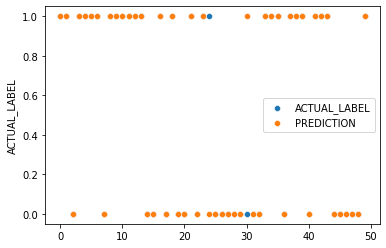

In [114]:
sns.scatterplot(data=df, x=df.index, y="ACTUAL_LABEL")
sns.scatterplot(data=df, x=df.index, y="PREDICTION")

plt.legend(labels=['ACTUAL_LABEL', 'PREDICTION'])

#### Save the predictions into Snowflake

In [45]:
%%time
# First create the table
list_val = [i+ " number" for i in combined_df.columns]
query = f""" create or replace table ANOMALY_PREDICTION ({','.join(map(str, list_val))})"""
session.sql(query).collect()

prediction_snowdf.write.mode("overwrite").saveAsTable("ANOMALY_PREDICTION") #push to snowflake

CPU times: user 18.1 ms, sys: 126 µs, total: 18.2 ms
Wall time: 2.72 s


<h2> References: </h2>
<ul>
    <li>Adopted from this <a href="https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets">Kaggle notebook</a></li>
<li>Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron  </li>
<li><a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s" > Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a>by Coding-Maniac</li>
<li><a src="https://www.kaggle.com/lane203j/auprc-5-fold-c-v-and-resampling-methods"> auprc, 5-fold c-v, and resampling methods
</a> by Jeremy Lane (Kaggle Notebook) </li>
</ul>